In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

데이터 불러오기 

data1 : phenotype_1000

data2 : KCPS

In [137]:
data1=pd.read_csv('C:/Users/dudtj/OneDrive - 숭실대학교 - Soongsil University/Desktop/CL/python/동계인턴십_Data_1000/phenotype_1000.txt',engine="python",sep=" ")

In [89]:
data2=pd.read_csv('C:/Users/dudtj/OneDrive - 숭실대학교 - Soongsil University/Desktop/CL/python/동계인턴십_Data_1000/KCPS_r2_0.01_1000.csv')

In [90]:
for i in range(2,15190):
    data2.columns.values[i]=i

In [138]:
df=data1.loc[:,['AGE_B', 'SMOK_B', 'ALCO_B','EXER_B','HT_B', 'WT_B', 'WAIST_B', 'SBP_B', 'DBP_B', 'CHO_B','LDL_B', 'TG_B', 'HDL_B', 'FBS_B', 'GOT_B', 'GPT_B', 'GGT_B', 'URIC_B','BIL', 'WBC', 'CREAT', 'STOMA', 'COLON', 'LIVER', 'LUNG','PROST', 'THROI', 'BREAC', 'RECTM','SEX1', 'CRC']]
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 788 entries, 0 to 999
Data columns (total 31 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   AGE_B    788 non-null    int64  
 1   SMOK_B   788 non-null    float64
 2   ALCO_B   788 non-null    float64
 3   EXER_B   788 non-null    float64
 4   HT_B     788 non-null    float64
 5   WT_B     788 non-null    float64
 6   WAIST_B  788 non-null    float64
 7   SBP_B    788 non-null    float64
 8   DBP_B    788 non-null    float64
 9   CHO_B    788 non-null    float64
 10  LDL_B    788 non-null    float64
 11  TG_B     788 non-null    float64
 12  HDL_B    788 non-null    float64
 13  FBS_B    788 non-null    float64
 14  GOT_B    788 non-null    float64
 15  GPT_B    788 non-null    float64
 16  GGT_B    788 non-null    float64
 17  URIC_B   788 non-null    float64
 18  BIL      788 non-null    float64
 19  WBC      788 non-null    float64
 20  CREAT    788 non-null    float64
 21  STOMA    788 non

In [139]:
df

,AGE_B,SMOK_B,ALCO_B,EXER_B,HT_B,WT_B,WAIST_B,SBP_B,DBP_B,CHO_B,...,STOMA,COLON,LIVER,LUNG,PROST,THROI,BREAC,RECTM,SEX1,CRC
0,48,3.0,2.0,1.0,168.0,69.8,82.0,102.0,69.0,196.0,...,0,0,0,0,0,0,0,0,1,0
1,53,1.0,2.0,1.0,161.0,67.9,86.0,127.0,67.0,159.0,...,0,0,0,0,0,0,1,0,2,0
2,60,1.0,1.0,2.0,153.0,73.3,97.0,133.0,76.0,198.0,...,0,0,0,0,0,0,0,0,2,0
3,42,1.0,2.0,2.0,167.0,65.1,77.5,97.0,70.0,139.0,...,1,0,0,0,0,0,0,0,1,0
4,57,3.0,2.0,2.0,165.0,51.8,73.0,98.0,76.0,166.0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,37,3.0,2.0,2.0,173.0,69.4,82.0,145.0,87.0,156.0,...,0,0,0,0,0,0,0,0,1,0
996,57,2.0,2.0,1.0,159.0,61.4,87.0,109.0,80.0,194.0,...,0,0,0,0,0,0,0,0,1,0
997,50,2.0,2.0,1.0,163.0,66.4,82.0,150.0,82.0,210.0,...,0,0,0,0,0,0,0,0,2,0
998,45,1.0,2.0,1.0,156.0,48.0,67.5,91.0,60.0,159.0,...,0,0,0,0,0,0,0,0,2,0


train/test data set 분할

먼저 전체 데이터 프레임에서 타겟값을 제외한 나머지 columns을 X_df로 설정하고, LUNG을 y_df로 설정한다.

In [78]:
#폐암 
features=['LUNG','STOMA','COLON','LIVER','LUNG','PROST','THROI','BREAC','RECTM']
y_df =df['LUNG']
X_df =df.drop(features, axis=1)

In [80]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_df,y_df,test_size=0.2)

In [18]:
#분류 모델
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import confusion_matrix,classification_report #정오분류표
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score #정확도,민감도
from sklearn.metrics import roc_curve, auc #ROC 곡선 그리기

#최적화
from sklearn.model_selection import learning_curve,validation_curve #학습곡선, 검증곡선
from sklearn.model_selection import GridSearchCV #하이퍼파라미터 튜닝
from sklearn.model_selection import cross_val_score #교차타당도 #추가

In [44]:
logistic = LogisticRegression(solver='liblinear',penalty='l2')
tree = DecisionTreeClassifier(max_depth=None,criterion='entropy')
knn = KNeighborsClassifier(n_neighbors=1,p=2,metric='minkowski')
forest = RandomForestClassifier()
adaboost = AdaBoostClassifier()
voting_estimators = [('logistic',logistic),('tree',tree),('knn',knn)]
voting = VotingClassifier(estimators=voting_estimators,voting='soft')
xgboost = XGBClassifier()

#투표 기법 사용
a_clf_labels = ['Logistic regression','Decision tree','KNN','randomforest','adaboost','Majority voting']
a_all_clf = [logistic,tree,knn,forest,adaboost,voting]

In [45]:
for clf, label in zip(a_all_clf,a_clf_labels):
    scores = cross_val_score(estimator=clf,X=X_train,y=y_train,cv=10,scoring='roc_auc')
    print('ROC AUC: %0.3f (sd : %0.3f),[%s]' %(scores.mean(),scores.std(),label))

ROC AUC: 0.727 (sd : 0.215),[Logistic regression]
ROC AUC: 0.587 (sd : 0.127),[Decision tree]
ROC AUC: 0.509 (sd : 0.078),[KNN]
ROC AUC: 0.696 (sd : 0.208),[randomforest]
ROC AUC: 0.635 (sd : 0.164),[adaboost]
ROC AUC: 0.748 (sd : 0.222),[Majority voting]


In [55]:
tree =DecisionTreeClassifier(max_depth=1,criterion='entropy',random_state=1)
adaboost = AdaBoostClassifier(base_estimator=tree,n_estimators=500,learning_rate=0.1,random_state=1)
clf_labels = ['Decision tree','Ada boost']
all_clf = [tree,adaboost]

In [56]:
for clf, label in zip(all_clf,clf_labels):
    scores = cross_val_score(estimator=clf,X=X_train,y=y_train,cv=10,scoring='roc_auc')
    print('ROC AUC: %0.3f (sd : %0.3f),[%s]' %(scores.mean(),scores.std(),label))

ROC AUC: 0.699 (sd : 0.188),[Decision tree]
ROC AUC: 0.672 (sd : 0.142),[Ada boost]


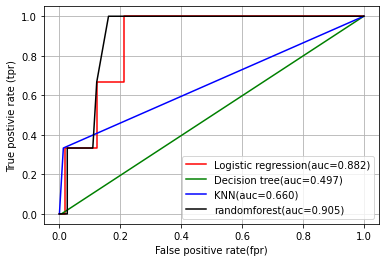

In [64]:
colors=['r','g','b','black']
for clf,label,clr in zip(a_all_clf,a_clf_labels,colors):
    clf.fit(X_train,y_train)
    y_pred = clf.predict_proba(X_test)[:,1]
    fpr,tpr,thresholds = roc_curve(y_true=y_test,y_score=y_pred)
    roc_auc=auc(x=fpr,y=tpr)
    plt.plot(fpr,tpr,color=clr,label='%s(auc=%0.3f)'%(label,roc_auc))

plt.legend(loc='lower right')
plt.grid()
plt.xlabel('False positive rate(fpr)')
plt.ylabel('True postivie rate (tpr)')
plt.show()

In [73]:
def get_clf_eval(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred)
    print('오차행렬:\n', confusion)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

In [83]:
clf=RandomForestClassifier()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
get_clf_eval(y_test,y_pred)

오차행렬:
 [[153   0]
 [  5   0]]

정확도: 0.9684
정밀도: 0.0000
재현율: 0.0000
F1: 0.0000
AUC: 0.5000


In [71]:
feat_labels= X_df.columns
importance =forest.feature_importances_
indices=np.argsort(importance)[::-1]
for f in range(X_train.shape[1]):
    print("%3d) %-*s %f" %(f+1,30,feat_labels[indices[f]],importance[indices[f]]))

  1) AGE_B                          0.108514
  2) GOT_B                          0.077085
  3) SBP_B                          0.064832
  4) HDL_B                          0.062711
  5) WT_B                           0.059504
  6) FBS_B                          0.054915
  7) WAIST_B                        0.054289
  8) CHO_B                          0.049357
  9) GPT_B                          0.048717
 10) HT_B                           0.045699
 11) DBP_B                          0.045323
 12) TG_B                           0.045227
 13) WBC                            0.044484
 14) GGT_B                          0.042215
 15) LDL_B                          0.040689
 16) URIC_B                         0.038571
 17) CREAT                          0.035953
 18) BIL                            0.029656
 19) SMOK_B                         0.026718
 20) EXER_B                         0.013359
 21) ALCO_B                         0.009999
 22) SEX1                           0.001828
 23) CRC  

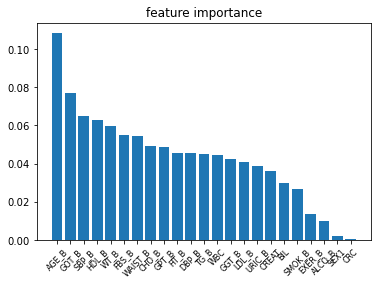

In [72]:
plt.bar(range(X_train.shape[1]),importance[indices],align='center')
plt.xticks(range(X_train.shape[1]),feat_labels[indices],rotation=45,size=8)
plt.title('feature importance')
plt.show()

In [86]:
df=data1.loc[:,['FID','AGE_B', 'SMOK_B', 'ALCO_B','EXER_B','HT_B', 'WT_B', 'WAIST_B', 'SBP_B', 'DBP_B', 'CHO_B','LDL_B', 'TG_B', 'HDL_B', 'FBS_B', 'GOT_B', 'GPT_B', 'GGT_B', 'URIC_B','BIL', 'WBC', 'CREAT', 'STOMA', 'COLON', 'LIVER', 'LUNG','PROST', 'THROI', 'BREAC', 'RECTM','SEX1', 'CRC']]
df.head()

,FID,AGE_B,SMOK_B,ALCO_B,EXER_B,HT_B,WT_B,WAIST_B,SBP_B,DBP_B,...,STOMA,COLON,LIVER,LUNG,PROST,THROI,BREAC,RECTM,SEX1,CRC
0,KCPS000029,48,3.0,2.0,1.0,168.0,69.8,82.0,102.0,69.0,...,0,0,0,0,0,0,0,0,1,0
1,KCPS000056,53,1.0,2.0,1.0,161.0,67.9,86.0,127.0,67.0,...,0,0,0,0,0,0,1,0,2,0
2,KCPS000058,60,1.0,1.0,2.0,153.0,73.3,97.0,133.0,76.0,...,0,0,0,0,0,0,0,0,2,0
3,KCPS000081,42,1.0,2.0,2.0,167.0,65.1,77.5,97.0,70.0,...,1,0,0,0,0,0,0,0,1,0
4,KCPS000087,57,3.0,2.0,2.0,165.0,51.8,73.0,98.0,76.0,...,0,0,0,0,0,0,0,0,1,0


In [135]:
df=data1.loc[:,['FID','AGE_B', 'SMOK_B', 'ALCO_B','EXER_B','HT_B', 'WT_B', 'WAIST_B', 'SBP_B', 'DBP_B', 'CHO_B','LDL_B', 'TG_B', 'HDL_B', 'FBS_B', 'GOT_B', 'GPT_B', 'GGT_B', 'URIC_B','BIL', 'WBC', 'CREAT', 'STOMA', 'COLON', 'LIVER', 'LUNG','PROST', 'THROI', 'BREAC', 'RECTM','SEX1', 'CRC']]
df.head()

,FID,AGE_B,SMOK_B,ALCO_B,EXER_B,HT_B,WT_B,WAIST_B,SBP_B,DBP_B,...,STOMA,COLON,LIVER,LUNG,PROST,THROI,BREAC,RECTM,SEX1,CRC
0,KCPS000029,48,3.0,2.0,1.0,168.0,69.8,82.0,102.0,69.0,...,0,0,0,0,0,0,0,0,1,0
1,KCPS000056,53,1.0,2.0,1.0,161.0,67.9,86.0,127.0,67.0,...,0,0,0,0,0,0,1,0,2,0
2,KCPS000058,60,1.0,1.0,2.0,153.0,73.3,97.0,133.0,76.0,...,0,0,0,0,0,0,0,0,2,0
3,KCPS000081,42,1.0,2.0,2.0,167.0,65.1,77.5,97.0,70.0,...,1,0,0,0,0,0,0,0,1,0
4,KCPS000087,57,3.0,2.0,2.0,165.0,51.8,73.0,98.0,76.0,...,0,0,0,0,0,0,0,0,1,0


In [136]:
data = pd.concat([df,data2],axis=1)

In [126]:
data.dropna(inplace=True)

In [127]:
data.drop('FID',axis=1,inplace=True)
data.drop('IID',axis=1,inplace=True)

In [128]:
#폐암 
features=['LUNG','STOMA','COLON','LIVER','PROST','THROI','BREAC','RECTM']
y_df =data['LUNG']
X_df =data.drop(features, axis=1)

In [129]:
X_df.columns

Index([   'HT_B',    'WT_B', 'WAIST_B',   'AGE_B',  'SMOK_B',  'ALCO_B',
          'SEX1',         2,         3,         4,
       ...
           15180,     15181,     15182,     15183,     15184,     15185,
           15186,     15187,     15188,     15189],
      dtype='object', length=15195)

In [130]:
# random_state = 156 : 다음에도 같은 데이터를 train, test로 분리 하는 옵션
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_df,y_df,test_size=0.2,random_state=156)

data2에 Ridge 회귀 적용

일반적으로 릿지를 선호한다고 한다.

In [131]:
ridge = Ridge(alpha=100).fit(X_train, y_train)

print("훈련 세트의 정확도 : {:.2f}".format(ridge.score(X_train,y_train)))
print("테스트 세트의 정확도 : {:.2f}".format(ridge.score(X_test,y_test)))

훈련 세트의 정확도 : 1.00
테스트 세트의 정확도 : 0.06


In [132]:
alphas = [0, 0.1, 1, 10, 100]

#alphas list값을 반복하면서 alpha에 따른 평균 rmse를 구함
for alpha in alphas:
    ridge = Ridge(alpha=alpha)

    #cross_val_score를 이용해 5folds의 평균 RMSE계산
    neg_mse_scores = cross_val_score(ridge, X_df, y_df, scoring='neg_mean_squared_error', cv=5)
    rmse_scores = np.sqrt(-1 * neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)
    print('alpha {0}일 때 5folds의 평균 RMSE: {1:.3f} '.format(alpha, avg_rmse))

alpha 0일 때 5folds의 평균 RMSE: 0.180 
alpha 0.1일 때 5folds의 평균 RMSE: 0.180 
alpha 1일 때 5folds의 평균 RMSE: 0.180 
alpha 10일 때 5folds의 평균 RMSE: 0.180 
alpha 100일 때 5folds의 평균 RMSE: 0.180 


라쏘

In [133]:
from sklearn.linear_model import Lasso
lasso = Lasso().fit(X_train, y_train)

print("훈련 세트의 정확도 : {:.2f}".format(lasso.score(X_train, y_train)))
print("테스트 세트의 정확도 : {:.2f}".format(lasso.score(X_test, y_test)))
print("사용한 특성의 수 : {}".format(np.sum(lasso.coef_ != 0)))
print("사용한 max_iter : {}".format(lasso.n_iter_))

훈련 세트의 정확도 : 0.00
테스트 세트의 정확도 : -0.00
사용한 특성의 수 : 0
사용한 max_iter : 1


In [134]:
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge

In [ ]:
ridge = Ridge()
ridge.fit(train)

In [ ]:
import mglearn

import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.linear_model import Lasso

X, y = mglearn.datasets.load_extended_boston()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)



lasso = Lasso().fit(X_train, y_train)